<a href="https://colab.research.google.com/github/brunotagoncalves/MeLi_2021_demand_prediction/blob/main/meli_EDA_10th_sub.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Read Data 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install catboost

     |████████████████████████████████| 69.2 MB 4.8 kB/s 


In [3]:
#!wget https://meli-data-challenge.s3.amazonaws.com/2021/test_data.csv -P drive/MyDrive/MeLi-2021/row/
#!wget https://meli-data-challenge.s3.amazonaws.com/2021/train_data.parquet -P drive/MyDrive/MeLi-2021/row/
#!wget https://meli-data-challenge.s3.amazonaws.com/2021/items_static_metadata_full.jl -P drive/MyDrive/MeLi-2021/row/
#!wget https://meli-data-challenge.s3.amazonaws.com/2021/sample_submission.csv.gz -P drive/MyDrive/MeLi-2021/row/

In [4]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
#!wget http://www-eu.apache.org/dist/spark/spark-2.4.8/spark-2.4.8-bin-hadoop2.7.tgz 
!wget -P spark_tgz/ http://www-eu.apache.org/dist/spark/spark-2.4.8/spark-2.4.8-bin-hadoop2.7.tgz

--2021-08-01 19:58:05--  http://www-eu.apache.org/dist/spark/spark-2.4.8/spark-2.4.8-bin-hadoop2.7.tgz
Resolving www-eu.apache.org (www-eu.apache.org)... 95.216.26.30, 2a01:4f9:2a:1a61::2
Connecting to www-eu.apache.org (www-eu.apache.org)|95.216.26.30|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://downloads.apache.org/spark/spark-2.4.8/spark-2.4.8-bin-hadoop2.7.tgz [following]
--2021-08-01 19:58:05--  https://downloads.apache.org/spark/spark-2.4.8/spark-2.4.8-bin-hadoop2.7.tgz
Resolving downloads.apache.org (downloads.apache.org)... 135.181.209.10, 88.99.95.219, 135.181.214.104, ...
Connecting to downloads.apache.org (downloads.apache.org)|135.181.209.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 235899716 (225M) [application/x-gzip]
Saving to: ‘spark_tgz/spark-2.4.8-bin-hadoop2.7.tgz’

spark-2.4.8-bin-had 100%[===================>] 224.97M  28.6MB/s    in 8.5s    

2021-08-01 19:58:14 (26.4 MB/s) - ‘spark_tgz/spark

In [5]:
!tar -xf spark_tgz/spark-2.4.8-bin-hadoop2.7.tgz -C spark_tgz/
!pip install -q findspark
!pip install -q pyspark

     |████████████████████████████████| 212.4 MB 61 kB/s 
     |████████████████████████████████| 198 kB 42.7 MB/s 


In [1]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark_tgz/spark-2.4.8-bin-hadoop2.7"

In [2]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()


In [3]:
import pyspark.sql.functions  as F
from pyspark.sql.window import *

In [4]:
import pandas as pd 
import numpy as np


In [51]:
df_spark = spark.read.format('parquet').load("drive/MyDrive/MeLi-2021/row/train_data.parquet")#.filter('sku=26')
df_spark.createOrReplaceTempView('df')

In [49]:
%%time
df_spark = spark.read.format('parquet').load("drive/MyDrive/MeLi-2021/row/train_data.parquet")#.filter('sku=26')
df_spark = df_spark.withColumn('row_sku',F.row_number().over(Window.partitionBy("sku").orderBy("date")))
df_spark = df_spark.withColumn('sold_quantity',F.when(F.col('minutes_active')>=1440.000000*8/24,F.col('sold_quantity')).otherwise(None))
for i in range(1,31):
  df_spark = df_spark.withColumn('lag_'+str(i)+'_sold_quantity',F.lag('sold_quantity',i).over(Window.partitionBy("sku").orderBy("date")))
df_spark = df_spark.filter('row_sku>=30')
df_spark = df_spark.withColumn('sum_sold_quantity',F.sum(F.col('sold_quantity')).over(Window.partitionBy("sku").orderBy("date")))
df_spark = df_spark.withColumn('sum_days_active',(F.sum(F.col('minutes_active')).over(Window.partitionBy("sku").orderBy("date"))/24/60).cast('int'))
df_spark = df_spark.filter('sold_quantity is not null ')
df_spark = df_spark.filter('sum_days_active > 0 or sum_sold_quantity> 0 ')
df_spark.repartition(1).write.mode('overwrite').format('parquet').save('drive/MyDrive/MeLi-2021/final/lag_vars/')

CPU times: user 1.39 s, sys: 161 ms, total: 1.55 s
Wall time: 4min


In [9]:
df = spark.read.format('parquet').load('drive/MyDrive/MeLi-2021/final/lag_vars/')
#df.describe('')#.toPandas()

In [16]:
df.createOrReplaceTempView('df_lags')

In [10]:
#df.filter('sum_minutes_active=29').limit(10).toPandas()
#df.filter('sku=474').toPandas()
df.count()

13549689

In [11]:
spark.sql(""" 
SELECT sku
  , sum(sold_quantity) sum_sold_quantity
  , max(sold_quantity) max_sold_quantity 
  , min(case when sold_quantity>0 then sold_quantity end) min_sold_quantity 
  , avg(case when sold_quantity>0 then sold_quantity end) avg_sold_quantity 
  , percentile_approx(case when sold_quantity>0 then sold_quantity end,.5) median_sold_quantity 
  , percentile_approx(case when sold_quantity>0 then sold_quantity end,.25) qt1_sold_quantity 
  , percentile_approx(case when sold_quantity>0 then sold_quantity end,.75) qt3_sold_quantity 

  , sum(current_price*sold_quantity) total_fat 
  , max(current_price*sold_quantity) max_fat  
  , min(case when sold_quantity>0 then current_price*sold_quantity end) min_fat 
  , avg(case when sold_quantity>0 then current_price*sold_quantity end) avg_fat
  , percentile_approx(case when sold_quantity>0 then current_price*sold_quantity end,.5) median_fat
  , percentile_approx(case when sold_quantity>0 then current_price*sold_quantity end,.25) qt1_fat
  , percentile_approx(case when sold_quantity>0 then current_price*sold_quantity end,.75) qt3_fat

  , sum(case when sold_quantity>0 then current_price*sold_quantity end)/sum(sold_quantity) avg_price
  , percentile_approx(case when sold_quantity>0 then current_price*sold_quantity end,.5)/sum(sold_quantity) median_price
  , percentile_approx(case when sold_quantity>0 then current_price*sold_quantity end,.25)/sum(sold_quantity) qt1_price
  , percentile_approx(case when sold_quantity>0 then current_price*sold_quantity end,.75)/sum(sold_quantity) qt3_price
  , sum(sold_quantity)/sum(minutes_active/60/24) tx_sell
FROM df
GROUP BY sku
""").createOrReplaceTempView('df_final')

In [12]:
spark.read.format('json').load('drive/MyDrive/MeLi-2021/row/items_static_metadata_full.jl').createOrReplaceTempView('items')


In [27]:
spark.sql("""
SELECT df_lags.*,
  max_sold_quantity,
  min_sold_quantity,
  avg_sold_quantity,
  median_sold_quantity,
  qt1_sold_quantity,
  qt3_sold_quantity,
  total_fat,
  max_fat,
  min_fat,
  avg_fat,
  median_fat,
  qt1_fat,
  qt3_fat,
  avg_price,
  median_price,
  qt1_price,
  qt3_price,
  item_domain_id ,
  item_id ,
  item_title ,
  product_family_id ,
  product_id ,
  site_id 

FROM df_lags
LEFT JOIN df_final 
  ON df_lags.sku = df_final.sku
LEFT JOIN items 
  ON items.sku = df_lags.sku
""").createOrReplaceTempView('df_final_join')

In [29]:
spark.sql("""select max(date) from df_final_join""").toPandas()

,max(date)
0,2021-03-31


modifcanco dados de submissão


In [28]:
spark.read.option("header",True).format('csv').load('drive/MyDrive/MeLi-2021/row/test_data.csv').createOrReplaceTempView('test_data')


In [52]:
spark.sql("""
SELECT 
  '2021-04-01' date,
  target_stock ,
  df_final.*,
  item_domain_id ,
  item_id ,
  item_title ,
  product_family_id ,
  product_id ,
  site_id 
FROM test_data
LEFT JOIN df_final 
  ON df_final .sku = test_data.sku
LEFT JOIN items 
  ON items.sku = test_data.sku
""").createOrReplaceTempView('test_data_join')

In [61]:
df_spark_submit = spark.sql("""
select * from df
union all 
SELECT test_data.sku,
  '2021-04-01' date,
  target_stock sold_quantity,
  df.current_price,
  df.currency,
  df.listing_type,
  df.shipping_logistic_type,
  df.shipping_payment,
  1440.0 minutes_active
FROM test_data
LEFT JOIN (select * from df where date='2021-03-31') df
  on df.sku  = test_data.sku  
""")#.filter('sku=100010')

In [62]:
%%time
#df_spark = spark.read.format('parquet').load("drive/MyDrive/MeLi-2021/row/train_data.parquet")#.filter('sku=26')
df_spark_submit = df_spark_submit.withColumn('row_sku',F.row_number().over(Window.partitionBy("sku").orderBy("date")))
df_spark_submit = df_spark_submit.withColumn('sold_quantity',F.when(F.col('minutes_active')>=1440.000000*8/24,F.col('sold_quantity')).otherwise(None))
for i in range(1,31):
  df_spark_submit = df_spark_submit.withColumn('lag_'+str(i)+'_sold_quantity',F.lag('sold_quantity',i).over(Window.partitionBy("sku").orderBy("date")))
df_spark_submit = df_spark_submit.filter("date='2021-04-01'")
df_spark_submit = df_spark_submit.withColumn('sum_sold_quantity',F.sum(F.col('sold_quantity')).over(Window.partitionBy("sku").orderBy("date")))
df_spark_submit = df_spark_submit.withColumn('sum_days_active',(F.sum(F.col('minutes_active')).over(Window.partitionBy("sku").orderBy("date"))/24/60).cast('int'))
df_spark_submit = df_spark_submit.filter('sold_quantity is not null ')
df_spark_submit = df_spark_submit.filter('sum_days_active > 0 or sum_sold_quantity> 0 ')
df_spark_submit.repartition(1).write.mode('overwrite').format('parquet').save('drive/MyDrive/MeLi-2021/final/submit_lag_vars/')

CPU times: user 1.48 s, sys: 190 ms, total: 1.67 s
Wall time: 3min 49s


In [63]:
submit_data = spark.read.format('parquet').load('drive/MyDrive/MeLi-2021/final/submit_lag_vars/')
submit_data.limit(10).toPandas()

,sku,date,sold_quantity,current_price,currency,listing_type,shipping_logistic_type,shipping_payment,minutes_active,row_sku,lag_1_sold_quantity,lag_2_sold_quantity,lag_3_sold_quantity,lag_4_sold_quantity,lag_5_sold_quantity,lag_6_sold_quantity,lag_7_sold_quantity,lag_8_sold_quantity,lag_9_sold_quantity,lag_10_sold_quantity,lag_11_sold_quantity,lag_12_sold_quantity,lag_13_sold_quantity,lag_14_sold_quantity,lag_15_sold_quantity,lag_16_sold_quantity,lag_17_sold_quantity,lag_18_sold_quantity,lag_19_sold_quantity,lag_20_sold_quantity,lag_21_sold_quantity,lag_22_sold_quantity,lag_23_sold_quantity,lag_24_sold_quantity,lag_25_sold_quantity,lag_26_sold_quantity,lag_27_sold_quantity,lag_28_sold_quantity,lag_29_sold_quantity,lag_30_sold_quantity,sum_sold_quantity,sum_days_active
0,100010,2021-04-01,4,115.00,MEX,classic,fulfillment,paid_shipping,1440.0,60,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,2,0,0,0,0,0,0,1,0,1,0,0,0,0,4.0,1
1,100140,2021-04-01,10,24819.00,ARG,premium,fulfillment,free_shipping,1440.0,60,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10.0,1
2,100227,2021-04-01,6,439.00,MEX,classic,fulfillment,free_shipping,1440.0,60,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,6.0,1
3,100263,2021-04-01,1,149.90,REA,classic,fulfillment,free_shipping,1440.0,60,1,2,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,1,1,2,0,0,1,1.0,1
4,100320,2021-04-01,2,192.00,MEX,premium,fulfillment,paid_shipping,1440.0,60,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,3,1,0,1,0,0,2,0,0,0,0,2.0,1
5,100704,2021-04-01,4,64.90,MEX,classic,fulfillment,paid_shipping,1440.0,60,1,1,1,0,1,1,1,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,1,0,1,2,0,1,1,4.0,1
6,100735,2021-04-01,5,61.75,REA,classic,fulfillment,paid_shipping,1440.0,60,None,None,None,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5.0,1
7,10096,2021-04-01,13,55.90,REA,classic,fulfillment,paid_shipping,1440.0,60,4,2,1,2,2,0,1,4,2,1,2,4,2,4,2,3,2,2,0,4,5,1,2,0,0,6,0,2,1,1,13.0,1
8,100964,2021-04-01,1,161.41,REA,classic,cross_docking,free_shipping,1440.0,60,0,0,0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,0,1,0,0,0,1,2,1,0,0,1.0,1
9,101021,2021-04-01,5,69.99,REA,classic,fulfillment,paid_shipping,1440.0,60,1,1,4,0,2,0,1,0,None,None,None,None,None,None,0,0,1,1,1,0,2,0,1,1,0,0,0,1,0,1,5.0,1


In [64]:
%%time
spark.sql("""
SELECT *
FROM df_final_join
""").repartition(1).write.mode('overwrite').format('parquet').save('drive/MyDrive/MeLi-2021/final/df_final_lags/')

CPU times: user 1.67 s, sys: 182 ms, total: 1.85 s
Wall time: 4min 48s


In [65]:
%%time
submit_data.createOrReplaceTempView('submit_data_join')
spark.sql("""
SELECT submit_data_join.*,
  max_sold_quantity,
  min_sold_quantity,
  avg_sold_quantity,
  median_sold_quantity,
  qt1_sold_quantity,
  qt3_sold_quantity,
  total_fat,
  max_fat,
  min_fat,
  avg_fat,
  median_fat,
  qt1_fat,
  qt3_fat,
  avg_price,
  median_price,
  qt1_price,
  qt3_price,
  item_domain_id ,
  item_id ,
  item_title ,
  product_family_id ,
  product_id ,
  site_id 

FROM submit_data_join
LEFT JOIN df_final 
  ON submit_data_join.sku = df_final.sku
LEFT JOIN items 
  ON items.sku = submit_data_join.sku
""").repartition(1).write.mode('overwrite').format('parquet').save('drive/MyDrive/MeLi-2021/final/submit_data_join/')

CPU times: user 219 ms, sys: 27.6 ms, total: 246 ms
Wall time: 38.4 s


In [79]:
df_final = spark.read.format('parquet').load('drive/MyDrive/MeLi-2021/final/df_final_lags/')
submit_data = spark.read.format('parquet').load('drive/MyDrive/MeLi-2021/final/submit_data_join/')

In [67]:
from catboost import Pool, CatBoostClassifier, CatBoostRegressor


In [69]:
df_train, df_test = df_final.sample(fraction=.02,seed=123).randomSplit([3.,1.],seed=123)

In [70]:
df_train.count(), df_test.count()

(202605, 67411)

In [80]:
vars = [ 'sum_sold_quantity','site_id','product_family_id','item_domain_id'#,'item_title'
 ]
cat_vars =  ['site_id','product_family_id','item_domain_id'
 ]
text_vars =['item_title']

df_train = df_train.fillna('sem_id', subset=cat_vars)
df_test = df_test.fillna('sem_id', subset=cat_vars) 
submit_data = submit_data.fillna('sem_id', subset=cat_vars)

train_data = df_train.select(*vars+['sum_days_active']).toPandas()
test_data = df_test.select(*vars+['sum_days_active']).toPandas()
train_label = train_data.sum_days_active
test_label = test_data.sum_days_active

In [83]:
# initialize data
#train_data = g_df.loc[:,vars].sample(frac=.01,random_state=123)
#train_label = g_df.loc[:,'days_active'].apply(lambda x : x if x<30. else 30.).round().astype(int).sample(frac=.01,random_state=123)
#test_data = g_df.loc[~g_df.sku.isnull(),'current_price_count':'shipping_payment_shipping_payment']#.sample(frac=.1,random_state=1234)
# initialize Pool
train_pool = Pool(train_data.loc[:,vars], 
                  train_label, 
                  cat_features=cat_vars)#,
                  #text_features = text_vars)
test_pool = Pool(test_data.loc[:,vars], 
                  test_label, 
                  cat_features=cat_vars)#,
                 #text_features = text_vars)

# specify the training parameters 
model = CatBoostClassifier(metric_period=100,learning_rate=0.01,task_type='GPU')
#train the model
model.fit(train_pool,eval_set=test_pool)
# make the prediction using the resulting model

CatBoostError: ignored

In [138]:
test = df_final.select(*['tx_sell']).toPandas()

In [130]:
test.describe()

,tx_sell
count,654730.000000
mean,1.745195
std,22.893464
min,0.000000
25%,0.271186
50%,0.538824
75%,1.227479
max,14269.812798


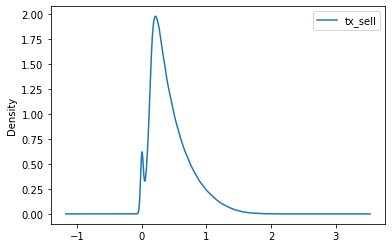

In [133]:
np.log1p(np.log1p(test)).plot.density()

In [85]:
submit_data = spark.read.format('parquet').load('drive/MyDrive/MeLi-2021/final/test_data_join_tx/')

In [ ]:
submit_data.limit(10).toPandas()

In [116]:
test = submit_data.select(*['sku','target_stock','tx_sell',F.expr('target_stock/tx_sell').alias('Pred')]).toPandas()

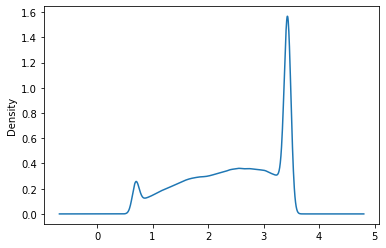

In [127]:
np.log1p(test.Pred.apply(lambda x : x if x<30 else 30.).apply(lambda x : x if x>1 else 1)).plot.density()

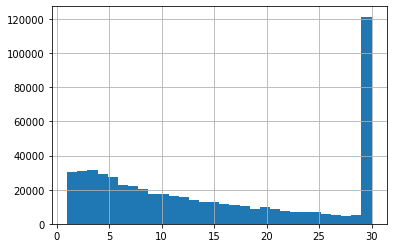

In [123]:
test.Pred.round().apply(lambda x : x if x<30 else 30).apply(lambda x : x if x>1 else 1).hist(bins=30)

In [118]:
result = pd.get_dummies(test.Pred.round().apply(lambda x : x if x<30 else 30).apply(lambda x : x if x>1 else 1))

In [119]:
result.shape

(551472, 30)

In [121]:
result.astype('float').round(4).to_csv("drive/MyDrive/MeLi-2021/results/challenger.csv.gz",compression='gzip',index=False,header=False)

In [35]:
result = pd.DataFrame(model.predict_proba(submit_pool))#.round(4)#.to_csv("test_inner.csv.gz",compression='gzip',index=False,header=False)

In [36]:
result.loc[:,29] = result.loc[:,29:].sum(axis=1)#.apply(lambda x : x if x<1. else 1. )

In [37]:
(result.loc[:,:29].round(4)>1).any(axis=1).sum()

0

In [38]:
result.loc[:,:29].round(4).to_csv("drive/MyDrive/MeLi-2021/results/challenger.csv.gz",compression='gzip',index=False,header=False)

In [59]:
result = pd.read_csv("drive/MyDrive/MeLi-2021/results/challenger.csv.gz",header=None)
winner = pd.read_csv("drive/MyDrive/MeLi-2021/results/test_inner (16).csv.gz",header=None)

In [60]:
result.idxmax(axis=1).describe()

count    551472.000000
mean         17.007473
std          13.210564
min           0.000000
25%           2.000000
50%          29.000000
75%          29.000000
max          29.000000
dtype: float64

In [61]:
winner.idxmax(axis=1).describe()

count    551472.000000
mean         19.563399
std          12.809139
min           0.000000
25%           3.000000
50%          29.000000
75%          29.000000
max          29.000000
dtype: float64

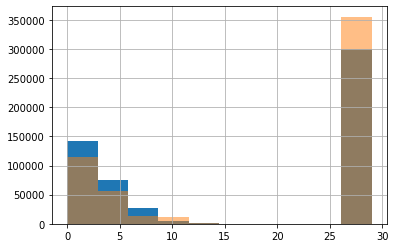

In [62]:
result.idxmax(axis=1).hist()
winner.idxmax(axis=1).hist(alpha=0.5)

In [63]:
np.corrcoef(result.idxmax(axis=1),winner.idxmax(axis=1))

array([[1.        , 0.66051745],
       [0.66051745, 1.        ]])